# MCMC Analysis of Eclipse Impact Parameter

This notebook performs MCMC analysis on the eclipse impact parameter $b_{\text{occ}}$ as defined in Winn (2010):

$$b_{\text{occ}} = \frac{a \cos i}{R_\star} \left(\frac{1 - e^2}{1 - e \sin \omega}\right)$$

which can be rewritten as:

$$b_{\text{occ}} = \frac{a}{R_\star} \cos i \left(\frac{1 - e^2}{1 - e \sin \omega}\right)$$

where:
- $a/R_\star$ = scaled semi-major axis (sampled as single parameter)
- $i$ = orbital inclination
- $e$ = eccentricity
- $\omega$ = argument of periastron

**Note:** We sample on $a/R_\star$ directly rather than separately on $a$ and $R_\star$, as this parameter is often better constrained observationally from transit light curves.

This analysis uses the updated MCS and TPC data files (2025-07-18).

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import emcee
import corner
from astropy import units as u
from astropy.constants import R_sun
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Load Data

In [2]:
# Load the updated data files
mcs_file = '../../data/raw/Ariel_MCS_Known_2025-07-18.csv'
tpc_file = '../../data/raw/Ariel_MCS_TPCs_2025-07-18.csv'

mcs_df = pd.read_csv(mcs_file)
tpc_df = pd.read_csv(tpc_file)

print(f"MCS Known Planets: {len(mcs_df)}")
print(f"TPC Candidates: {len(tpc_df)}")
print(f"\nTotal systems to analyze: {len(mcs_df) + len(tpc_df)}")

MCS Known Planets: 808
TPC Candidates: 2046

Total systems to analyze: 2854


## 2. Identify Required Columns and Extract Parameters

In [3]:
# Define the columns needed for the eclipse impact parameter calculation
# Column names differ between MCS and TPC files

# For MCS (Known Planets)
mcs_columns = {
    'name': 'Planet Name',
    'a_over_rs': 'a/Rs',
    'a_over_rs_err_lower': 'a/Rs Error Lower',
    'a_over_rs_err_upper': 'a/Rs Error Upper',
    'inclination': 'Inclination',
    'inclination_err_lower': 'Inclination Error Lower',
    'inclination_err_upper': 'Inclination Error Upper',
    'impact_parameter': 'Impact Parameter',
    'impact_parameter_err_lower': 'Impact Parameter Error Lower',
    'impact_parameter_err_upper': 'Impact Parameter Error Upper',
    'eccentricity': 'Eccentricity',
    'eccentricity_err_lower': 'Eccentricity Error Lower',
    'eccentricity_err_upper': 'Eccentricity Error Upper',
    'periastron': 'Periastron',
    'periastron_err_lower': 'Periastron Error Lower',
    'periastron_err_upper': 'Periastron Error Upper',
    'rp_rs': 'Rp/Rs',
    'rp_rs_err_lower': 'Rp/Rs Error Lower',
    'rp_rs_err_upper': 'Rp/Rs Error Upper',
    'eclipse_flag': 'Eclipse Flag'
}

# For TPC (Candidates)
tpc_columns = {
    'name': 'Planet Name',
    'a_over_rs': 'a/Rs',
    'inclination': 'Inclination',
    'impact_parameter': 'Impact Parameter',
    'eccentricity': 'Eccentricity',
    'periastron': 'Periastron',
    'rp_rs': 'Rp/Rs'
}

print("MCS Columns:")
for key, col in mcs_columns.items():
    if col in mcs_df.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} - NOT FOUND")

print("\nTPC Columns:")
for key, col in tpc_columns.items():
    if col in tpc_df.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} - NOT FOUND")

MCS Columns:
  ✓ Planet Name
  ✓ a/Rs
  ✓ a/Rs Error Lower
  ✓ a/Rs Error Upper
  ✓ Inclination
  ✓ Inclination Error Lower
  ✓ Inclination Error Upper
  ✓ Impact Parameter
  ✓ Impact Parameter Error Lower
  ✓ Impact Parameter Error Upper
  ✓ Eccentricity
  ✓ Eccentricity Error Lower
  ✓ Eccentricity Error Upper
  ✓ Periastron
  ✓ Periastron Error Lower
  ✓ Periastron Error Upper
  ✓ Rp/Rs
  ✓ Rp/Rs Error Lower
  ✓ Rp/Rs Error Upper
  ✓ Eclipse Flag

TPC Columns:
  ✓ Planet Name
  ✓ a/Rs
  ✓ Inclination
  ✓ Impact Parameter
  ✓ Eccentricity
  ✓ Periastron
  ✓ Rp/Rs


## 3. Define the Eclipse Impact Parameter Model

In [4]:
def eclipse_impact_parameter(a_over_rs, inclination_deg, eccentricity, periastron_deg):
    """
    Calculate the eclipse impact parameter b_occ.
    
    Formula from Winn (2010):
    b_occ = (a/R*) * cos(i) * ((1 - e^2) / (1 - e * sin(omega)))
    
    Parameters:
    -----------
    a_over_rs : float
        Scaled semi-major axis (a/R*), dimensionless
    inclination_deg : float
        Orbital inclination in degrees
    eccentricity : float
        Orbital eccentricity
    periastron_deg : float
        Argument of periastron in degrees
    
    Returns:
    --------
    b_occ : float
        Eclipse impact parameter (dimensionless)
    """
    # Convert to radians
    i_rad = np.radians(inclination_deg)
    omega_rad = np.radians(periastron_deg)
    
    # Eccentricity correction factor
    ecc_factor = (1 - eccentricity**2) / (1 - eccentricity * np.sin(omega_rad))
    
    # Calculate the eclipse impact parameter
    b_occ = a_over_rs * np.cos(i_rad) * ecc_factor
    
    return b_occ

def transit_impact_to_inclination(b_tra, a_over_rs):
    """
    Convert transit impact parameter to inclination.
    
    Parameters:
    -----------
    b_tra : float
        Transit impact parameter
    a_over_rs : float
        Scaled semi-major axis (a/R*)
    
    Returns:
    --------
    i_deg : float
        Inclination in degrees
    """
    # Clip b_tra to avoid numerical issues
    b_clipped = np.clip(b_tra, -1.5, 1.5)
    cos_i = b_clipped / a_over_rs
    # Ensure cos_i is in valid range
    cos_i = np.clip(cos_i, -1.0, 1.0)
    i_rad = np.arccos(cos_i)
    i_deg = np.degrees(i_rad)
    return i_deg

# Test the function with sample values
test_b_occ = eclipse_impact_parameter(
    a_over_rs=10.0,
    inclination_deg=89.0,
    eccentricity=0.0,
    periastron_deg=90.0
)
print(f"Test b_occ calculation: {test_b_occ:.4f}")

# Test inclination conversion
test_i = transit_impact_to_inclination(b_tra=0.3, a_over_rs=10.0)
print(f"Test inclination from b_tra: {test_i:.2f} degrees")

Test b_occ calculation: 0.1745
Test inclination from b_tra: 88.28 degrees


## 4. Prepare Data for MCMC

Extract systems with complete parameter information for MCMC analysis.

In [5]:
def prepare_system_data(df, is_mcs=True):
    """
    Prepare system data for MCMC analysis.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe (MCS or TPC)
    is_mcs : bool
        Whether the dataframe is MCS (True) or TPC (False)
    
    Returns:
    --------
    systems : list of dict
        List of systems with required parameters and uncertainties
    """
    systems = []
    
    for idx, row in df.iterrows():
        # Extract parameters based on dataset type
        if is_mcs:
            name = row.get('Planet Name', f'MCS_{idx}')
            a_over_rs = row.get('a/Rs')
            a_over_rs_err_lower = abs(row.get('a/Rs Error Lower', 0))
            a_over_rs_err_upper = abs(row.get('a/Rs Error Upper', 0))
            b_tra = row.get('Impact Parameter')  # Transit impact parameter
            b_tra_err_lower = abs(row.get('Impact Parameter Error Lower', 0))
            b_tra_err_upper = abs(row.get('Impact Parameter Error Upper', 0))
            inclination = row.get('Inclination')
            inclination_err_lower = abs(row.get('Inclination Error Lower', 0))
            inclination_err_upper = abs(row.get('Inclination Error Upper', 0))
            eccentricity = row.get('Eccentricity', 0.0)
            eccentricity_err_lower = abs(row.get('Eccentricity Error Lower', 0))
            eccentricity_err_upper = abs(row.get('Eccentricity Error Upper', 0))
            periastron = row.get('Periastron', 90.0)
            periastron_err_lower = abs(row.get('Periastron Error Lower', 0))
            periastron_err_upper = abs(row.get('Periastron Error Upper', 0))
            rp_rs = row.get('Rp/Rs')
            rp_rs_err_lower = abs(row.get('Rp/Rs Error Lower', 0))
            rp_rs_err_upper = abs(row.get('Rp/Rs Error Upper', 0))
            eclipse_flag = row.get('Eclipse Flag', False)
            # Convert string 'TRUE'/'FALSE' to boolean
            if isinstance(eclipse_flag, str):
                eclipse_flag = eclipse_flag.upper() == 'TRUE'
        else:  # TPC
            name = row.get('Planet Name', f'TPC_{idx}')
            a_over_rs = row.get('a/Rs')
            a_over_rs_err_lower = 0.0  # Not available in TPC
            a_over_rs_err_upper = 0.0
            b_tra = row.get('Impact Parameter')
            b_tra_err_lower = 0.0
            b_tra_err_upper = 0.0
            inclination = row.get('Inclination')
            inclination_err_lower = 0.0  # Not available in TPC
            inclination_err_upper = 0.0
            eccentricity = row.get('Eccentricity', 0.0)
            eccentricity_err_lower = 0.0
            eccentricity_err_upper = 0.0
            periastron = row.get('Periastron', 90.0)
            periastron_err_lower = 0.0
            periastron_err_upper = 0.0
            rp_rs = row.get('Rp/Rs')
            rp_rs_err_lower = 0.0
            rp_rs_err_upper = 0.0
            eclipse_flag = None  # Not available in TPC
        
        # Check if all required parameters are available and valid
        if all([pd.notna(x) for x in [a_over_rs, inclination]]):
            # Handle NaN values with defaults
            if pd.isna(eccentricity):
                eccentricity = 0.0
            if pd.isna(periastron):
                periastron = 90.0
            if pd.isna(b_tra):
                # Derive from inclination and a/Rs if not available
                b_tra = a_over_rs * np.cos(np.radians(inclination))
            if pd.isna(rp_rs):
                rp_rs = 0.1  # Default placeholder
            
            # Average uncertainties or use defaults
            a_over_rs_err = (a_over_rs_err_lower + a_over_rs_err_upper) / 2 if (a_over_rs_err_lower + a_over_rs_err_upper) > 0 else a_over_rs * 0.05
            b_tra_err = (b_tra_err_lower + b_tra_err_upper) / 2 if (b_tra_err_lower + b_tra_err_upper) > 0 else 0.05
            inclination_err = (inclination_err_lower + inclination_err_upper) / 2 if (inclination_err_lower + inclination_err_upper) > 0 else 0.5
            eccentricity_err = (eccentricity_err_lower + eccentricity_err_upper) / 2 if (eccentricity_err_lower + eccentricity_err_upper) > 0 else 0.01
            periastron_err = (periastron_err_lower + periastron_err_upper) / 2 if (periastron_err_lower + periastron_err_upper) > 0 else 10.0
            rp_rs_err = (rp_rs_err_lower + rp_rs_err_upper) / 2 if (rp_rs_err_lower + rp_rs_err_upper) > 0 else rp_rs * 0.05
            
            # Compute cos(i) and its uncertainty for direct sampling
            cos_i = np.cos(np.radians(inclination))
            # Propagate inclination uncertainty to cos(i) using: d(cos i)/di = -sin(i)
            cos_i_err = abs(np.sin(np.radians(inclination)) * np.radians(inclination_err))
            if cos_i_err == 0:
                cos_i_err = 0.01  # Default minimum uncertainty
            
            systems.append({
                'name': name,
                'a_over_rs': a_over_rs,
                'a_over_rs_err': a_over_rs_err,
                'b_tra': b_tra,
                'b_tra_err': b_tra_err,
                'inclination': inclination,
                'inclination_err': inclination_err,
                'cos_i': cos_i,
                'cos_i_err': cos_i_err,
                'eccentricity': eccentricity,
                'eccentricity_err': eccentricity_err,
                'periastron': periastron,
                'periastron_err': periastron_err,
                'rp_rs': rp_rs,
                'eclipse_flag': eclipse_flag,
                'dataset': 'MCS' if is_mcs else 'TPC'
            })
    
    return systems

# Prepare data from both datasets
mcs_systems = prepare_system_data(mcs_df, is_mcs=True)
tpc_systems = prepare_system_data(tpc_df, is_mcs=False)

all_systems = mcs_systems + tpc_systems

print(f"Systems prepared for MCMC:")
print(f"  MCS: {len(mcs_systems)}")
print(f"  TPC: {len(tpc_systems)}")
print(f"  Total: {len(all_systems)}")

# Display first few systems
if len(all_systems) > 0:
    print(f"\nExample system: {all_systems[0]['name']}")
    for key, val in all_systems[0].items():
        if key != 'name':
            print(f"  {key}: {val}")

Systems prepared for MCMC:
  MCS: 808
  TPC: 2046
  Total: 2854

Example system: K2-232b
  a_over_rs: 17.28
  a_over_rs_err: 0.54
  b_tra: 0.108
  b_tra_err: 0.076
  inclination: 89.61
  inclination_err: 0.275
  cos_i: 0.006806731520561874
  cos_i_err: 0.004799544253852854
  eccentricity: 0.255
  eccentricity_err: 0.035
  periastron: 170.9
  periastron_err: 172.85
  rp_rs: 0.08811
  eclipse_flag: False
  dataset: MCS


## 5. MCMC Setup

Define the log-likelihood and log-prior functions for the MCMC analysis.

In [6]:
# Import required for priors
from scipy.stats import beta as beta_dist
from scipy.stats import norm

# ---------------------------------------------------------------------
# Eccentricity prior (Kipping-style Beta prior)
# ---------------------------------------------------------------------

def beta_prior_ecc(e, alpha=0.867, beta=3.03):
    """
    Kipping-style Beta prior for eccentricity (suitable for short-period planets).
    Returns log probability.
    
    Parameters
    ----------
    e : float
        Eccentricity value.
    alpha, beta : float
        Beta distribution parameters (Kipping 2013/2014 defaults).
    
    Returns
    -------
    log_prob : float
        Log probability.
    """
    if e < 0.0 or e >= 1.0:
        return -np.inf
    lp = beta_dist.logpdf(e, alpha, beta)
    if not np.isfinite(lp):
        return -np.inf
    return lp


# ---------------------------------------------------------------------
# Priors: theta = [a_over_rs, cos_i, e, omega_deg]
# system = dict with transit-based constraints
#   system['a_over_rs'], system['a_over_rs_err']
#   system['cos_i'], system['cos_i_err']
#   system['rp_rs']
# ---------------------------------------------------------------------

def log_prior(theta, system):
    """
    Log prior probability with informative priors based on transit observations.
    
    Parameters
    ----------
    theta : array-like
        [a_over_rs, cos_i, e, omega_deg]
    system : dict
        System parameters and uncertainties from transit fits.
    
    Returns
    -------
    log_prob : float
        Log prior probability.
    """
    a_over_rs, cos_i, e, omega_deg = theta
    
    # Physical bounds
    if a_over_rs <= 0.0:
        return -np.inf
    if e < 0.0 or e >= 1.0:
        return -np.inf
    if omega_deg < 0.0 or omega_deg >= 360.0:
        return -np.inf
    if cos_i < -1.0 or cos_i > 1.0:
        return -np.inf
    
    log_prob = 0.0
    
    # Gaussian prior on a/Rs (from transit + stellar modeling)
    log_prob += norm.logpdf(
        a_over_rs,
        loc=system['a_over_rs'],
        scale=system['a_over_rs_err']
    )
    
    # Gaussian prior on cos(i) (derived once from transit solution)
    log_prob += norm.logpdf(
        cos_i,
        loc=system['cos_i'],
        scale=system['cos_i_err']
    )
    
    # Kipping-style Beta prior on eccentricity (favors low e for short-period planets)
    log_prob += beta_prior_ecc(e, alpha=0.867, beta=3.03)
    
    # Uniform prior on omega in [0, 360): normalization is constant, can be skipped
    return log_prob


# ---------------------------------------------------------------------
# Flat likelihood: no observational constraints beyond transits
# ---------------------------------------------------------------------

def log_likelihood(theta, system):
    """
    Log 'likelihood' function.
    
    For this analysis, we use a flat likelihood (returns 0.0) because all
    observational constraints are already encoded in the priors:
    - Transit observations constrain a/Rs and cos(i)
    - Eccentricity prior from population studies
    
    This allows the posterior b_occ distribution to naturally reflect the
    uncertainty about eclipse detectability without artificially forcing
    all systems to have eclipses.
    
    Note: We removed the hard constraint |b_occ| <= 1+k because:
    1. It artificially biased results for systems without observed eclipses
    2. Sound priors should naturally constrain systems appropriately
    3. We want true posterior uncertainty about eclipse probability
    """
    # Flat likelihood: all parameter combinations consistent with priors are equally likely
    return 0.0


# ---------------------------------------------------------------------
# Posterior
# ---------------------------------------------------------------------

def log_probability(theta, system):
    """
    Log posterior probability: prior + likelihood.
    """
    lp = log_prior(theta, system)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, system)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll


print("MCMC geometry / prior functions defined successfully.")


MCMC geometry / prior functions defined successfully.


## 6. Run MCMC for Selected Systems

Run MCMC to propagate uncertainties through the eclipse impact parameter calculation.

In [7]:
def run_mcmc_for_system(system, nwalkers=32, nsteps=5000, burn_in=1000):
    """
    Run MCMC for a single system with informative priors.
    
    Parameters:
    -----------
    system : dict
        System parameters
    nwalkers : int
        Number of MCMC walkers
    nsteps : int
        Number of MCMC steps
    burn_in : int
        Number of burn-in steps to discard
    
    Returns:
    --------
    results : dict
        MCMC results including samples and b_occ distribution
    """
    # Number of parameters: a/Rs, cos(i), e, omega
    ndim = 4
    
    # Initial positions for walkers
    p0 = np.array([
        system['a_over_rs'],
        system['cos_i'],
        system['eccentricity'],
        system['periastron']
    ])
    
    # Add random offsets with guaranteed minimum spread to avoid linear dependence
    perturbation_scale = np.array([
        max(system['a_over_rs_err'] * 0.1, system['a_over_rs'] * 0.01),  # At least 1% of a/Rs
        max(system['cos_i_err'] * 0.1, 0.01),  # At least 0.01 in cos(i)
        max(system['eccentricity_err'] * 0.1, 0.05),  # At least 0.05 in e
        max(system['periastron_err'] * 0.1, 10.0)  # At least 10 degrees in omega
    ])
    
    pos = p0 + np.random.randn(nwalkers, ndim) * perturbation_scale
    
    # Ensure all walkers start in valid parameter space
    # Clip a/Rs to positive values with reasonable bounds
    pos[:, 0] = np.clip(pos[:, 0], p0[0] * 0.8, p0[0] * 1.2)
    # Clip cos(i) to valid range
    pos[:, 1] = np.clip(pos[:, 1], -1.0, 1.0)
    # Clip eccentricity to [0, 1)
    pos[:, 2] = np.clip(pos[:, 2], 0.0, 0.99)
    # Wrap omega to [0, 360)
    pos[:, 3] = pos[:, 3] % 360.0
    
    # Initialize sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(system,))
    
    # Run MCMC (suppress progress bar output for batch processing)
    sampler.run_mcmc(pos, nsteps, progress=False)
    
    # Get samples after burn-in
    samples = sampler.get_chain(discard=burn_in, flat=True)
    
    # Calculate derived quantities for each sample
    b_occ_samples = []
    i_deg_samples = []
    
    for s in samples:
        a_over_rs, cos_i, e, omega = s
        # Derive inclination from cos(i)
        cos_i_clipped = np.clip(cos_i, -1.0, 1.0)
        i_deg = np.degrees(np.arccos(cos_i_clipped))
        i_deg_samples.append(i_deg)
        
        # Calculate b_occ
        b_occ = eclipse_impact_parameter(a_over_rs, i_deg, e, omega)
        b_occ_samples.append(b_occ)
    
    b_occ_samples = np.array(b_occ_samples)
    i_deg_samples = np.array(i_deg_samples)
    
    # Calculate statistics
    b_occ_median = np.median(b_occ_samples)
    b_occ_std = np.std(b_occ_samples)
    b_occ_16, b_occ_84 = np.percentile(b_occ_samples, [16, 84])
    
    i_median = np.median(i_deg_samples)
    i_16, i_84 = np.percentile(i_deg_samples, [16, 84])
    
    # Calculate k (planet-to-star radius ratio) from system parameters
    k = system['rp_rs']
    
    results = {
        'name': system['name'],
        'dataset': system['dataset'],
        'eclipse_flag': system['eclipse_flag'],
        'samples': samples,
        'b_occ_samples': b_occ_samples,
        'i_deg_samples': i_deg_samples,
        'b_occ_median': b_occ_median,
        'b_occ_std': b_occ_std,
        'b_occ_16': b_occ_16,
        'b_occ_84': b_occ_84,
        'b_occ_err_lower': b_occ_median - b_occ_16,
        'b_occ_err_upper': b_occ_84 - b_occ_median,
        'i_median': i_median,
        'i_err_lower': i_median - i_16,
        'i_err_upper': i_84 - i_median,
        'k': k,
        'acceptance_fraction': np.mean(sampler.acceptance_fraction)
    }
    
    return results

print("MCMC runner function defined.")

MCMC runner function defined.


## 7. Analyze First Few Systems (Example)

Run MCMC on the first few systems to demonstrate the analysis.

In [8]:
# Find systems with observed eclipses and run MCMC on them
systems_with_eclipse = [s for s in all_systems if s['eclipse_flag'] == True]
systems_without_eclipse = [s for s in all_systems if s['eclipse_flag'] == False]

print(f"Systems with observed eclipses: {len(systems_with_eclipse)}")
print(f"Systems without observed eclipses: {len(systems_without_eclipse)}")
print(f"Systems with unknown eclipse status (TPC): {len([s for s in all_systems if s['eclipse_flag'] is None])}")

# Run MCMC on first 3 systems with observed eclipses
n_examples = min(3, len(systems_with_eclipse))
mcmc_results = []

print(f"\n{'='*60}")
print(f"Running MCMC on {n_examples} systems WITH observed eclipses")
print(f"{'='*60}\n")

for i in range(n_examples):
    system = systems_with_eclipse[i]
    try:
        result = run_mcmc_for_system(system, nwalkers=32, nsteps=3000, burn_in=500)
        mcmc_results.append(result)
    except Exception as e:
        print(f"Error processing {system['name']}: {e}")
        continue

Systems with observed eclipses: 99
Systems without observed eclipses: 709
Systems with unknown eclipse status (TPC): 2046

Running MCMC on 3 systems WITH observed eclipses



## 8. Visualize Results

Create corner plots and posterior distributions for the MCMC results.

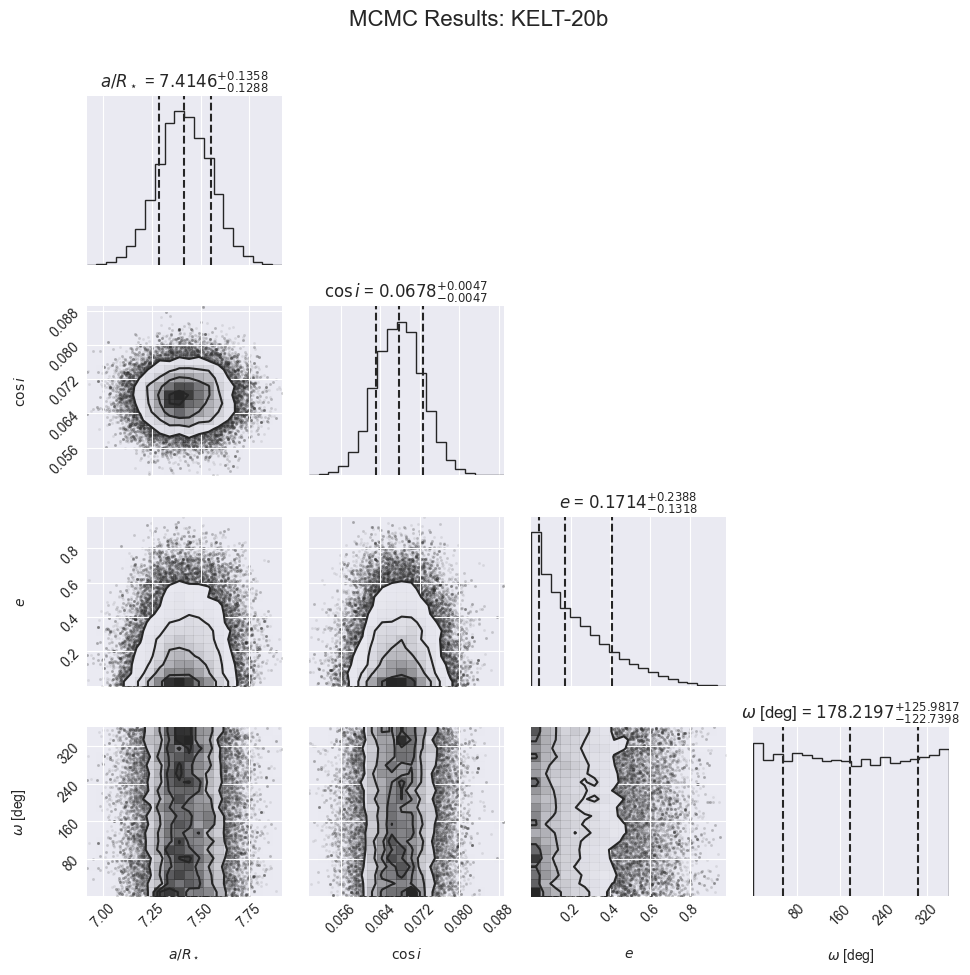

In [9]:
# Plot corner plot for the first system
if len(mcmc_results) > 0:
    result = mcmc_results[0]
    
    labels = [r'$a/R_\star$', r'$\cos i$', r'$e$', r'$\omega$ [deg]']
    
    fig = corner.corner(
        result['samples'],
        labels=labels,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_fmt='.4f',
        title_kwargs={"fontsize": 12}
    )
    
    fig.suptitle(f"MCMC Results: {result['name']}", fontsize=16, y=1.01)
    plt.tight_layout()
    plt.show()

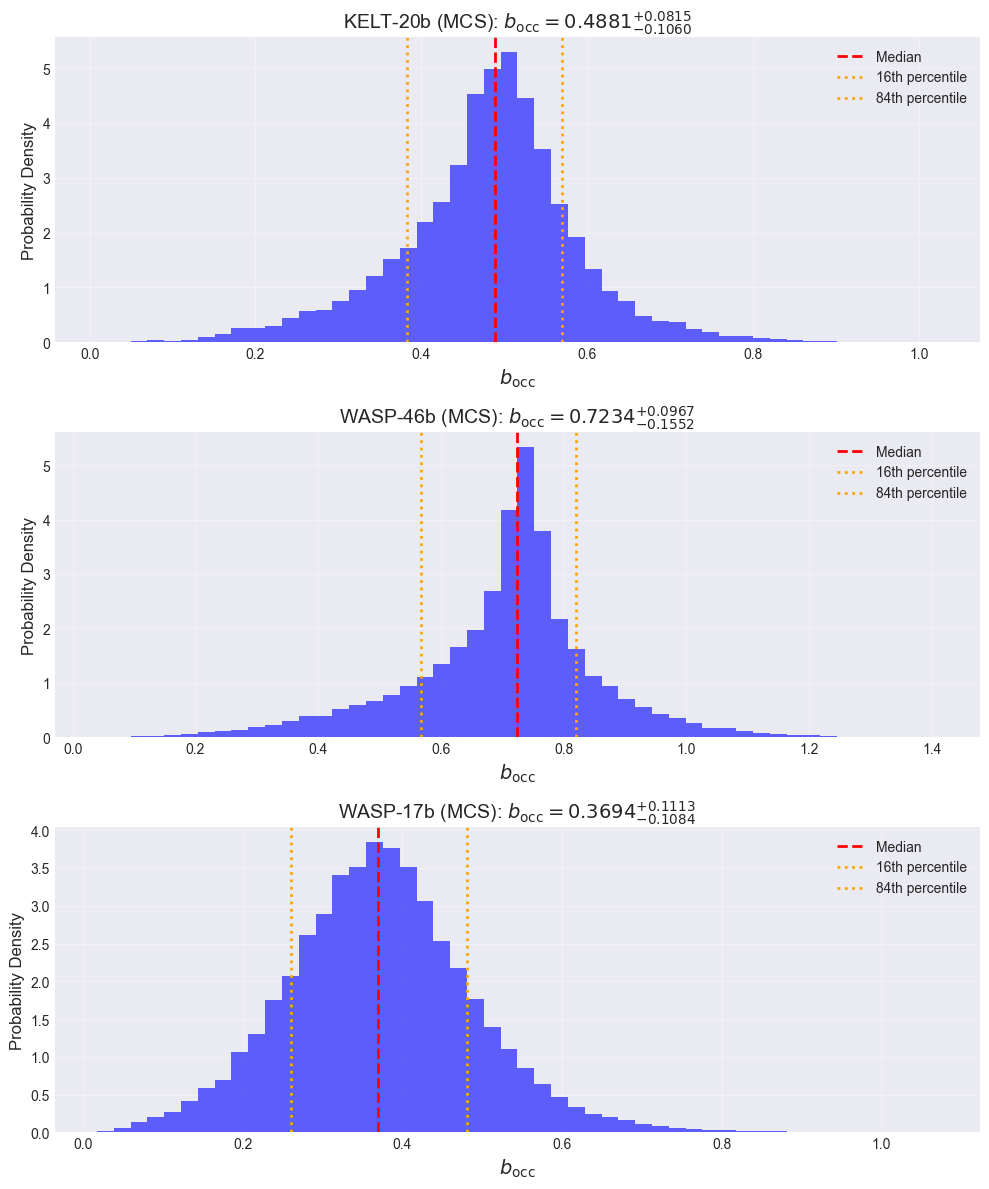

In [10]:
# Plot b_occ distributions for all analyzed systems
if len(mcmc_results) > 0:
    fig, axes = plt.subplots(len(mcmc_results), 1, figsize=(10, 4*len(mcmc_results)))
    
    if len(mcmc_results) == 1:
        axes = [axes]
    
    for i, result in enumerate(mcmc_results):
        ax = axes[i]
        
        # Histogram of b_occ
        ax.hist(result['b_occ_samples'], bins=50, density=True, alpha=0.6, color='blue')
        
        # Mark median and percentiles
        ax.axvline(result['b_occ_median'], color='red', linestyle='--', linewidth=2, label='Median')
        ax.axvline(result['b_occ_median'] - result['b_occ_err_lower'], color='orange', linestyle=':', linewidth=2, label='16th percentile')
        ax.axvline(result['b_occ_median'] + result['b_occ_err_upper'], color='orange', linestyle=':', linewidth=2, label='84th percentile')
        
        ax.set_xlabel(r'$b_{\rm occ}$', fontsize=14)
        ax.set_ylabel('Probability Density', fontsize=12)
        ax.set_title(f"{result['name']} ({result['dataset']}): $b_{{\\rm occ}} = {result['b_occ_median']:.4f}^{{+{result['b_occ_err_upper']:.4f}}}_{{-{result['b_occ_err_lower']:.4f}}}$", fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Summary Table

Create a summary table of the MCMC results.

In [11]:
# Create summary DataFrame
if len(mcmc_results) > 0:
    summary_data = []
    
    for result in mcmc_results:
        summary_data.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'Eclipse Observed': result['eclipse_flag'],
            'b_occ (median)': f"{result['b_occ_median']:.4f}",
            'b_occ_16': f"{result['b_occ_16']:.4f}",
            'b_occ_84': f"{result['b_occ_84']:.4f}",
            'k (Rp/Rs)': f"{result['k']:.4f}",
            '1+k': f"{1+result['k']:.4f}",
            'Acceptance Fraction': f"{result['acceptance_fraction']:.3f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)

,Planet,Dataset,Eclipse Observed,b_occ (median),b_occ_16,b_occ_84,k (Rp/Rs),1+k,Acceptance Fraction
0,KELT-20b,MCS,True,0.4881,0.3821,0.5696,0.1144,1.1144,0.493
1,WASP-46b,MCS,True,0.7234,0.5682,0.8201,0.1407,1.1407,0.493
2,WASP-17b,MCS,True,0.3694,0.2610,0.4806,0.1302,1.1302,0.496


## 10. Run Full Analysis (Optional)

Uncomment and run this cell to perform MCMC analysis on all systems. 
**Warning: This may take considerable time depending on the number of systems.**

In [12]:
# Run MCMC on ALL SYSTEMS (both MCS and TPC) - RESUME MODE
import time
import os

print("="*70)
print("PROCESSING ALL SYSTEMS - RESUME MODE")
print("="*70)
print(f"MCS systems: {len(mcs_systems)}")
print(f"TPC systems: {len(tpc_systems)}")
print(f"Total: {len(mcs_systems) + len(tpc_systems)}")
print("="*70)

# Output files
mcs_output_file = '../results/mcs_eclipse_impact_parameter_mcmc.csv'
tpc_output_file = '../results/tpc_eclipse_impact_parameter_mcmc.csv'
combined_output_file = '../results/eclipse_impact_parameter_mcmc_combined.csv'

overall_start_time = time.time()

# ============================================================
# PART 1: Process MCS systems
# ============================================================
print("\nProcessing MCS systems...")

# Load existing results if available
mcs_processed_names = set()
mcs_results_list = []
if os.path.exists(mcs_output_file):
    existing_mcs = pd.read_csv(mcs_output_file)
    mcs_processed_names = set(existing_mcs['Planet'].values)
    mcs_results_list = existing_mcs.to_dict('records')
    print(f"Loaded {len(mcs_processed_names)} existing MCS results")

# Filter to unprocessed systems
mcs_to_process = [s for s in mcs_systems if s['name'] not in mcs_processed_names]
print(f"Processing {len(mcs_to_process)} new MCS systems (skipping {len(mcs_processed_names)} existing)")

mcs_start_time = time.time()
new_mcs_count = 0

for i, system in enumerate(mcs_to_process, 1):
    try:
        planet_start = time.time()
        
        result = run_mcmc_for_system(system, nwalkers=32, nsteps=3000, burn_in=500)
        mcs_results_list.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'eclipse_observed': result['eclipse_flag'],
            'b_occ_median': result['b_occ_median'],
            'b_occ_16': result['b_occ_16'],
            'b_occ_84': result['b_occ_84'],
            'b_occ_std': result['b_occ_std'],
            'b_occ_err_lower': result['b_occ_err_lower'],
            'b_occ_err_upper': result['b_occ_err_upper'],
            'k_rp_rs': result['k'],
            'one_minus_k': 1 - result['k'],
            'one_plus_k': 1 + result['k'],
            'acceptance_fraction': result['acceptance_fraction']
        })
        new_mcs_count += 1
        
        # Show timing and progress
        planet_time = time.time() - planet_start
        elapsed_total = time.time() - mcs_start_time
        avg_time = elapsed_total / new_mcs_count
        remaining = avg_time * (len(mcs_to_process) - new_mcs_count) / 60
        print(f"✓ MCS [{i}/{len(mcs_to_process)}] {system['name']} - {planet_time:.1f}s (avg: {avg_time:.1f}s, ETA: {remaining:.1f} min)")
        
        # Save checkpoint every 50 NEW systems
        if new_mcs_count % 50 == 0:
            checkpoint_df = pd.DataFrame(mcs_results_list)
            checkpoint_df.to_csv(mcs_output_file, index=False)
            
    except Exception as e:
        print(f"\nERROR processing {system['name']}: {e}")
        continue

# Save MCS final results
if len(mcs_results_list) > 0:
    mcs_df = pd.DataFrame(mcs_results_list)
    mcs_df.to_csv(mcs_output_file, index=False)
    if new_mcs_count > 0:
        mcs_elapsed = time.time() - mcs_start_time
        print(f"✓ MCS complete: {new_mcs_count} new systems processed in {mcs_elapsed/60:.1f} min ({mcs_elapsed/new_mcs_count:.1f} sec/planet)")
        print(f"  Total MCS results: {len(mcs_results_list)}")
    else:
        print(f"✓ MCS: All {len(mcs_results_list)} systems already processed")

# ============================================================
# PART 2: Process TPC systems
# ============================================================
print("\nProcessing TPC systems...")

# Load existing results if available
tpc_processed_names = set()
tpc_results_list = []
if os.path.exists(tpc_output_file):
    existing_tpc = pd.read_csv(tpc_output_file)
    tpc_processed_names = set(existing_tpc['Planet'].values)
    tpc_results_list = existing_tpc.to_dict('records')
    print(f"Loaded {len(tpc_processed_names)} existing TPC results")

# Filter to unprocessed systems
tpc_to_process = [s for s in tpc_systems if s['name'] not in tpc_processed_names]
print(f"Processing {len(tpc_to_process)} new TPC systems (skipping {len(tpc_processed_names)} existing)")

tpc_start_time = time.time()
new_tpc_count = 0

for i, system in enumerate(tpc_to_process, 1):
    try:
        planet_start = time.time()
        
        result = run_mcmc_for_system(system, nwalkers=32, nsteps=3000, burn_in=500)
        tpc_results_list.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'eclipse_observed': result['eclipse_flag'],
            'b_occ_median': result['b_occ_median'],
            'b_occ_16': result['b_occ_16'],
            'b_occ_84': result['b_occ_84'],
            'b_occ_std': result['b_occ_std'],
            'b_occ_err_lower': result['b_occ_err_lower'],
            'b_occ_err_upper': result['b_occ_err_upper'],
            'k_rp_rs': result['k'],
            'one_minus_k': 1 - result['k'],
            'one_plus_k': 1 + result['k'],
            'acceptance_fraction': result['acceptance_fraction']
        })
        new_tpc_count += 1
        
        # Show timing and progress
        planet_time = time.time() - planet_start
        elapsed_total = time.time() - tpc_start_time
        avg_time = elapsed_total / new_tpc_count
        remaining = avg_time * (len(tpc_to_process) - new_tpc_count) / 60
        print(f"✓ TPC [{i}/{len(tpc_to_process)}] {system['name']} - {planet_time:.1f}s (avg: {avg_time:.1f}s, ETA: {remaining:.1f} min)")
        
        # Save checkpoint every 50 NEW systems
        if new_tpc_count % 50 == 0:
            checkpoint_df = pd.DataFrame(tpc_results_list)
            checkpoint_df.to_csv(tpc_output_file, index=False)
            
    except Exception as e:
        print(f"\nERROR processing {system['name']}: {e}")
        continue

# Save TPC final results
if len(tpc_results_list) > 0:
    tpc_df = pd.DataFrame(tpc_results_list)
    tpc_df.to_csv(tpc_output_file, index=False)
    if new_tpc_count > 0:
        tpc_elapsed = time.time() - tpc_start_time
        print(f"✓ TPC complete: {new_tpc_count} new systems processed in {tpc_elapsed/60:.1f} min ({tpc_elapsed/new_tpc_count:.1f} sec/planet)")
        print(f"  Total TPC results: {len(tpc_results_list)}")
    else:
        print(f"✓ TPC: All {len(tpc_results_list)} systems already processed")

# ============================================================
# PART 3: Combine and save all results
# ============================================================
if len(mcs_results_list) > 0 or len(tpc_results_list) > 0:
    all_results = []
    if len(mcs_results_list) > 0:
        all_results.extend(mcs_results_list)
    if len(tpc_results_list) > 0:
        all_results.extend(tpc_results_list)
    
    combined_df = pd.DataFrame(all_results)
    combined_df.to_csv(combined_output_file, index=False)
    
    overall_elapsed = time.time() - overall_start_time
    print("\n" + "="*70)
    print("ALL SYSTEMS ANALYSIS COMPLETE")
    print("="*70)
    print(f"MCS: {len(mcs_results_list)} total systems")
    print(f"TPC: {len(tpc_results_list)} total systems")
    print(f"Total: {len(all_results)} systems")
    print(f"New systems processed: {new_mcs_count + new_tpc_count}")    
    print("="*70)

    print(f"Time: {overall_elapsed/60:.1f} min")
    print(f"Time: {overall_elapsed/60:.1f} min")    
    print("="*70)

    print(f"\nResults saved to:")
    print(f"\nResults saved to:")    
    print(f"  Combined: {combined_output_file}")

    print(f"  MCS: {mcs_output_file}")
    print(f"  MCS: {mcs_output_file}")    
    print(f"  Combined: {combined_output_file}")

    print(f"  TPC: {tpc_output_file}")    
    print(f"  TPC: {tpc_output_file}")

PROCESSING ALL SYSTEMS - RESUME MODE
MCS systems: 808
TPC systems: 2046
Total: 2854

Processing MCS systems...
Processing 808 new MCS systems (skipping 0 existing)
✓ MCS [1/808] K2-232b - 5.8s (avg: 5.8s, ETA: 77.8 min)
✓ MCS [2/808] Qatar-10b - 5.9s (avg: 5.8s, ETA: 78.5 min)
✓ MCS [3/808] WASP-60b - 5.9s (avg: 5.9s, ETA: 78.8 min)
✓ MCS [4/808] WASP-20b - 5.9s (avg: 5.9s, ETA: 78.7 min)
✓ MCS [5/808] HATS-52b - 6.6s (avg: 6.0s, ETA: 80.6 min)
✓ MCS [6/808] TOI-1820b - 5.8s (avg: 6.0s, ETA: 80.1 min)
✓ MCS [7/808] TOI-2202b - 5.8s (avg: 6.0s, ETA: 79.6 min)
✓ MCS [8/808] TOI-4087b - 5.8s (avg: 5.9s, ETA: 79.2 min)
✓ MCS [9/808] WASP-2b - 5.8s (avg: 5.9s, ETA: 78.9 min)
✓ MCS [10/808] K2-237b - 5.8s (avg: 5.9s, ETA: 78.7 min)
✓ MCS [11/808] KELT-20b - 5.8s (avg: 5.9s, ETA: 78.4 min)
✓ MCS [12/808] WASP-107b - 5.8s (avg: 5.9s, ETA: 78.1 min)
✓ MCS [13/808] TOI-2498b - 5.8s (avg: 5.9s, ETA: 78.0 min)
✓ MCS [14/808] WASP-197b - 5.8s (avg: 5.9s, ETA: 77.8 min)
✓ MCS [15/808] WASP-187b - 5.

## 11. Load and Display Results

Load the saved MCMC results and display summary statistics. Run this after Cell 10 completes.

In [13]:
# Load and display the MCMC results from Cell 10
import os
import pandas as pd

# File paths (these were created by Cell 10)
mcs_file = '../results/mcs_eclipse_impact_parameter_mcmc.csv'
tpc_file = '../results/tpc_eclipse_impact_parameter_mcmc.csv'
combined_file = '../results/eclipse_impact_parameter_mcmc_combined.csv'

# ============================================================
# MCS RESULTS
# ============================================================
if os.path.exists(mcs_file):
    print("="*70)
    print("MCS RESULTS")
    print("="*70)
    mcs_df = pd.read_csv(mcs_file)
    print(f"Loaded: {len(mcs_df)} MCS systems")
    
    print(f"\nb_occ Statistics:")
    print(f"  Mean:   {mcs_df['b_occ_median'].mean():.4f}")
    print(f"  Median: {mcs_df['b_occ_median'].median():.4f}")
    print(f"  Std:    {mcs_df['b_occ_median'].std():.4f}")
    print(f"  Min:    {mcs_df['b_occ_median'].min():.4f}")
    print(f"  Max:    {mcs_df['b_occ_median'].max():.4f}")
    
    if 'acceptance_fraction' in mcs_df.columns:
        print(f"\nAcceptance Fraction:")
        print(f"  Mean: {mcs_df['acceptance_fraction'].mean():.3f}")
        print(f"  Std:  {mcs_df['acceptance_fraction'].std():.3f}")
    
    print(f"\nFirst 5 systems:")
    display(mcs_df.head())
else:
    print(f"MCS file not found: {mcs_file}")
    print("Run Cell 10 first to generate results.")

print("\n")

# ============================================================
# TPC RESULTS
# ============================================================
if os.path.exists(tpc_file):
    print("="*70)
    print("TPC RESULTS")
    print("="*70)
    tpc_df = pd.read_csv(tpc_file)
    print(f"Loaded: {len(tpc_df)} TPC systems")
    
    print(f"\nb_occ Statistics:")
    print(f"  Mean:   {tpc_df['b_occ_median'].mean():.4f}")
    print(f"  Median: {tpc_df['b_occ_median'].median():.4f}")
    print(f"  Std:    {tpc_df['b_occ_median'].std():.4f}")
    print(f"  Min:    {tpc_df['b_occ_median'].min():.4f}")
    print(f"  Max:    {tpc_df['b_occ_median'].max():.4f}")
    
    if 'acceptance_fraction' in tpc_df.columns:
        print(f"\nAcceptance Fraction:")
        print(f"  Mean: {tpc_df['acceptance_fraction'].mean():.3f}")
        print(f"  Std:  {tpc_df['acceptance_fraction'].std():.3f}")
    
    print(f"\nFirst 5 systems:")
    display(tpc_df.head())
else:
    print(f"TPC file not found: {tpc_file}")
    print("Run Cell 10 first to generate results.")

print("\n")

# ============================================================
# COMBINED RESULTS
# ============================================================
if os.path.exists(combined_file):
    print("="*70)
    print("COMBINED RESULTS (MCS + TPC)")
    print("="*70)
    
    combined_df = pd.read_csv(combined_file)
    print(f"Total systems: {len(combined_df)}")
    
    # Dataset breakdown
    if 'Dataset' in combined_df.columns:
        print(f"\nBy Dataset:")
        for dataset in combined_df['Dataset'].unique():
            count = len(combined_df[combined_df['Dataset'] == dataset])
            pct = 100 * count / len(combined_df)
            print(f"  {dataset}: {count:4d} ({pct:5.1f}%)")
    
    print(f"\nb_occ Statistics (All):")
    print(f"  Mean:   {combined_df['b_occ_median'].mean():.4f}")
    print(f"  Median: {combined_df['b_occ_median'].median():.4f}")
    print(f"  Std:    {combined_df['b_occ_median'].std():.4f}")
    print(f"  Min:    {combined_df['b_occ_median'].min():.4f}")
    print(f"  Max:    {combined_df['b_occ_median'].max():.4f}")
    
    if 'acceptance_fraction' in combined_df.columns:
        print(f"\nAcceptance Fraction (All):")
        print(f"  Mean: {combined_df['acceptance_fraction'].mean():.3f}")
        print(f"  Std:  {combined_df['acceptance_fraction'].std():.3f}")
        print(f"  Min:  {combined_df['acceptance_fraction'].min():.3f}")
        print(f"  Max:  {combined_df['acceptance_fraction'].max():.3f}")
    
    # Show systems with best eclipse prospects (lowest |b_occ_84|)
    print(f"\nTop 10 systems with lowest |b_occ_84| (best eclipse prospects):")
    combined_df['abs_b_occ_84'] = combined_df['b_occ_84'].abs()
    top10 = combined_df.nsmallest(10, 'abs_b_occ_84')
    display(top10[['Planet', 'Dataset', 'b_occ_median', 'b_occ_84', 'abs_b_occ_84', 
                    'k_rp_rs', 'one_plus_k', 'acceptance_fraction']])
else:
    print(f"Combined file not found: {combined_file}")
    print("Run Cell 10 first to generate results.")

MCS RESULTS
Loaded: 808 MCS systems

b_occ Statistics:
  Mean:   0.4434
  Median: 0.4156
  Std:    0.2663
  Min:    -0.9173
  Max:    1.3064

Acceptance Fraction:
  Mean: 0.495
  Std:  0.002

First 5 systems:


,Planet,Dataset,eclipse_observed,b_occ_median,b_occ_16,b_occ_84,b_occ_std,b_occ_err_lower,b_occ_err_upper,k_rp_rs,one_minus_k,one_plus_k,acceptance_fraction
0,K2-232b,MCS,False,0.108497,0.028319,0.199770,0.087795,0.080178,0.091273,0.088110,0.911890,1.088110,0.495427
1,Qatar-10b,MCS,False,0.329138,0.226816,0.439807,0.110100,0.102322,0.110669,0.126500,0.873500,1.126500,0.492677
2,WASP-60b,MCS,False,0.337115,0.075208,0.626965,0.290520,0.261907,0.289851,0.077523,0.922477,1.077523,0.492312
3,WASP-20b,MCS,False,0.699220,0.545897,0.807602,0.157890,0.153323,0.108382,0.107930,0.892070,1.107930,0.491604
4,HATS-52b,MCS,False,0.448388,0.314825,0.587241,0.141546,0.133563,0.138853,0.135200,0.864800,1.135200,0.494500




TPC RESULTS
Loaded: 2046 TPC systems

b_occ Statistics:
  Mean:   -0.0000
  Median: -0.0000
  Std:    0.0035
  Min:    -0.0259
  Max:    0.0374

Acceptance Fraction:
  Mean: 0.496
  Std:  0.002

First 5 systems:


,Planet,Dataset,eclipse_observed,b_occ_median,b_occ_16,b_occ_84,b_occ_std,b_occ_err_lower,b_occ_err_upper,k_rp_rs,one_minus_k,one_plus_k,acceptance_fraction
0,TOI-1007.01,TPC,NaN,0.000985,-0.051527,0.051951,0.054751,0.052511,0.050966,0.053292,0.946708,1.053292,0.493094
1,TOI-1009.01,TPC,NaN,-0.000009,-0.033331,0.033065,0.035097,0.033322,0.033074,0.041323,0.958677,1.041323,0.494552
2,TOI-1019.01,TPC,NaN,0.000648,-0.079536,0.083647,0.084408,0.080183,0.082999,0.144211,0.855789,1.144211,0.495906
3,TOI-1027.01,TPC,NaN,-0.001126,-0.095802,0.092652,0.101166,0.094675,0.093779,0.039472,0.960528,1.039472,0.490552
4,TOI-1027.02,TPC,NaN,0.005023,-0.221521,0.225592,0.231786,0.226544,0.220569,0.041158,0.958842,1.041158,0.498781




COMBINED RESULTS (MCS + TPC)
Total systems: 2854

By Dataset:
  MCS:  808 ( 28.3%)
  TPC: 2046 ( 71.7%)

b_occ Statistics (All):
  Mean:   0.1255
  Median: 0.0008
  Std:    0.2450
  Min:    -0.9173
  Max:    1.3064

Acceptance Fraction (All):
  Mean: 0.496
  Std:  0.002
  Min:  0.487
  Max:  0.503

Top 10 systems with lowest |b_occ_84| (best eclipse prospects):


,Planet,Dataset,b_occ_median,b_occ_84,abs_b_occ_84,k_rp_rs,one_plus_k,acceptance_fraction
1337,TOI-326.01,TPC,-0.000052,0.007750,0.007750,0.080283,1.080283,0.495083
253,TrES-1b,MCS,-0.000290,0.008411,0.008411,0.136614,1.136614,0.490958
882,TOI-1560.01,TPC,0.000298,0.009113,0.009113,0.028508,1.028508,0.492302
1700,TOI-4243.01,TPC,0.000023,0.009314,0.009314,0.020302,1.020302,0.494792
2033,TOI-5342.01,TPC,-0.000091,0.010163,0.010163,0.031937,1.031937,0.499677
1303,TOI-3195.01,TPC,-0.000228,0.010274,0.010274,0.058652,1.058652,0.493531
1407,TOI-3443.01,TPC,-0.000839,0.010453,0.010453,0.042308,1.042308,0.499885
2042,TOI-5364.01,TPC,-0.000426,0.010719,0.010719,0.026268,1.026268,0.495271
1503,TOI-3668.01,TPC,0.000418,0.010743,0.010743,0.048394,1.048394,0.492385
1200,TOI-2955.01,TPC,-0.000238,0.010974,0.010974,0.066332,1.066332,0.494156


## 12. Summary Statistics and Plots (Optional)

Run this cell after batch processing to generate summary statistics and distribution plots.

In [14]:
# Generate summary statistics after batch processing
# This cell is optional - run only after full batch analysis completes

if 'mcs_mcmc_results' in locals() and len(mcs_mcmc_results) > 0:
    print("="*70)
    print("MCS (KNOWN PLANETS) SUMMARY")
    print("="*70)
    
    mcs_tiers = [r['tier'] for r in mcs_mcmc_results]
    mcs_with_eclipse = [r for r in mcs_mcmc_results if r['eclipse_flag'] == True]
    mcs_without_eclipse = [r for r in mcs_mcmc_results if r['eclipse_flag'] == False]
    
    print(f"\nTotal systems analyzed: {len(mcs_mcmc_results)}")
    print(f"  With observed eclipses: {len(mcs_with_eclipse)}")
    print(f"  Without observed eclipses: {len(mcs_without_eclipse)}")
    
    print(f"\nTier Distribution:")
    for tier in [1, 2, 3, 4]:
        count = mcs_tiers.count(tier)
        pct = 100 * count / len(mcs_tiers)
        print(f"  Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Tier distribution for systems WITH observed eclipses
    if len(mcs_with_eclipse) > 0:
        print(f"\nTier Distribution (Eclipse Observed):")
        eclipse_tiers = [r['tier'] for r in mcs_with_eclipse]
        for tier in [1, 2, 3, 4]:
            count = eclipse_tiers.count(tier)
            pct = 100 * count / len(eclipse_tiers) if len(eclipse_tiers) > 0 else 0
            print(f"  Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Acceptance fraction statistics
    accept_fracs = [r['acceptance_fraction'] for r in mcs_mcmc_results]
    print(f"\nAcceptance Fraction: {np.mean(accept_fracs):.3f} ± {np.std(accept_fracs):.3f}")
    print(f"  Range: [{np.min(accept_fracs):.3f}, {np.max(accept_fracs):.3f}]")

if 'tpc_mcmc_results' in locals() and len(tpc_mcmc_results) > 0:
    print("\n" + "="*70)
    print("TPC (TIER 1 CANDIDATES) SUMMARY")
    print("="*70)
    
    tpc_tiers = [r['tier'] for r in tpc_mcmc_results]
    
    print(f"\nTotal systems analyzed: {len(tpc_mcmc_results)}")
    
    print(f"\nTier Distribution:")
    for tier in [1, 2, 3, 4]:
        count = tpc_tiers.count(tier)
        pct = 100 * count / len(tpc_tiers)
        print(f"  Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Acceptance fraction statistics
    accept_fracs = [r['acceptance_fraction'] for r in tpc_mcmc_results]
    print(f"\nAcceptance Fraction: {np.mean(accept_fracs):.3f} ± {np.std(accept_fracs):.3f}")
    print(f"  Range: [{np.min(accept_fracs):.3f}, {np.max(accept_fracs):.3f}]")

LOADED TPC RESULTS: 2046 systems

TOP 10 TPC SYSTEMS (Lowest |b_occ_84| values - Best for eclipses)

──────────────────────────────────────────────────────────────────────
System: TOI-326.01
──────────────────────────────────────────────────────────────────────
  b_occ (median): -0.0001  |b_occ|: 0.0001
  b_occ (16th):   -0.0077
  b_occ (84th):   +0.0077  |b_occ_84|: 0.0077
  Error range:    +0.0078 / -0.0077
  k (Rp/Rs):      0.0803
  1-k:            0.9197
  1+k:            1.0803
  Acceptance:     0.495

──────────────────────────────────────────────────────────────────────
System: TOI-1560.01
──────────────────────────────────────────────────────────────────────
  b_occ (median): +0.0003  |b_occ|: 0.0003
  b_occ (16th):   -0.0085
  b_occ (84th):   +0.0091  |b_occ_84|: 0.0091
  Error range:    +0.0088 / -0.0088
  k (Rp/Rs):      0.0285
  1-k:            0.9715
  1+k:            1.0285
  Acceptance:     0.492

──────────────────────────────────────────────────────────────────────
Sys

,Planet,b_occ_median,abs_b_occ_84,k_rp_rs,one_minus_k,one_plus_k,acceptance_fraction
529,TOI-326.01,-0.000052,0.007750,0.080283,0.919717,1.080283,0.495083
74,TOI-1560.01,0.000298,0.009113,0.028508,0.971492,1.028508,0.492302
892,TOI-4243.01,0.000023,0.009314,0.020302,0.979698,1.020302,0.494792
1225,TOI-5342.01,-0.000091,0.010163,0.031937,0.968063,1.031937,0.499677
495,TOI-3195.01,-0.000228,0.010274,0.058652,0.941348,1.058652,0.493531
599,TOI-3443.01,-0.000839,0.010453,0.042308,0.957692,1.042308,0.499885
1234,TOI-5364.01,-0.000426,0.010719,0.026268,0.973732,1.026268,0.495271
695,TOI-3668.01,0.000418,0.010743,0.048394,0.951606,1.048394,0.492385
392,TOI-2955.01,-0.000238,0.010974,0.066332,0.933668,1.066332,0.494156
125,TOI-1966.01,-0.000155,0.011884,0.023790,0.976210,1.023790,0.496917



TPC GRAZING ECLIPSE SYSTEMS
Systems where (1-k) < |b_occ_84| < (1+k) - Partial/Grazing eclipses

Found 2 grazing systems (0.1% of TPC)

Top 10 grazing systems (closest to 1-k boundary):
  TOI-4409.01                    | b_occ=+0.0319 | |b_occ_84|=0.9245 | k=0.1072 | (1-k)=0.8928
  TOI-7049.01                    | b_occ=+0.0374 | |b_occ_84|=0.9772 | k=0.0810 | (1-k)=0.9190




,Planet,b_occ_median,abs_b_occ_84,k_rp_rs,lower_grazing,upper_grazing,acceptance_fraction
931,TOI-4409.01,0.031927,0.924507,0.107180,0.892820,1.107180,0.499396
1845,TOI-7049.01,0.037384,0.977198,0.080963,0.919037,1.080963,0.497688



TPC ECLIPSE CATEGORIES
Non-grazing (|b_occ_84| < 1-k):     2044 ( 99.9%)
Grazing (1-k < |b_occ_84| < 1+k):      2 (  0.1%)
No eclipse (|b_occ_84| > 1+k):         0 (  0.0%)
Total:                               2046

GENERATING TPC VISUALIZATIONS


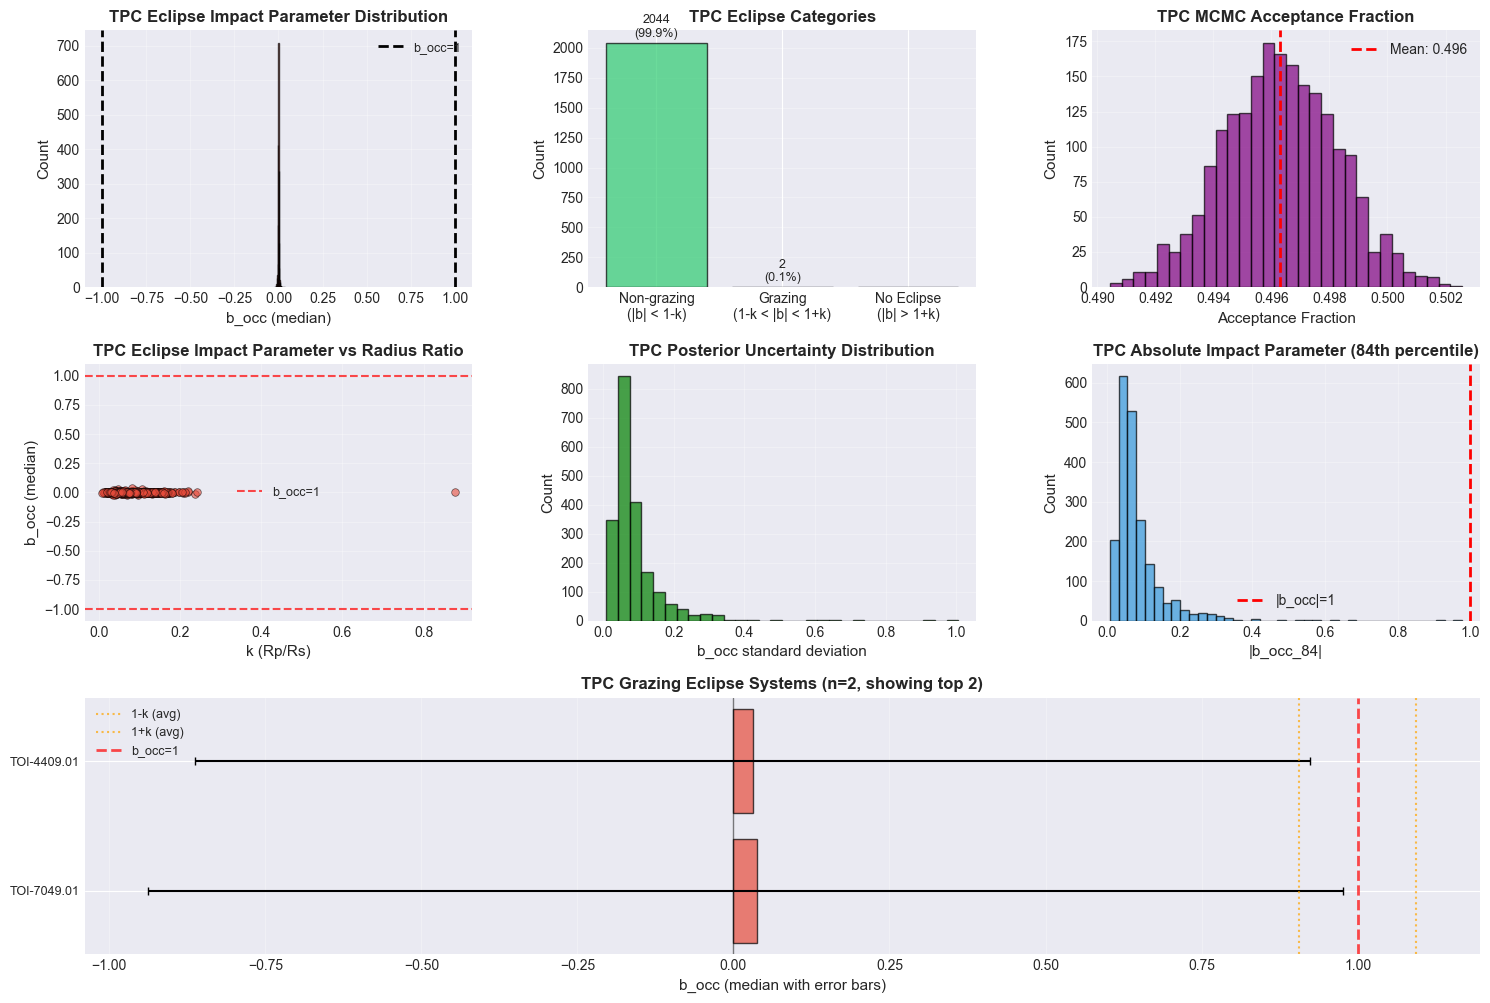


TPC ANALYSIS COMPLETE


In [21]:
# Load and visualize TPC MCMC results only
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load only TPC results
tpc_file = '../results/tpc_eclipse_impact_parameter_mcmc.csv'

if os.path.exists(tpc_file):
    tpc_df = pd.read_csv(tpc_file)
    print("="*70)
    print(f"LOADED TPC RESULTS: {len(tpc_df)} systems")
    print("="*70)
    
    # Add absolute value columns for proper sorting
    tpc_df['abs_b_occ_median'] = tpc_df['b_occ_median'].abs()
    tpc_df['abs_b_occ_84'] = tpc_df['b_occ_84'].abs()
    
    # ============================================================
    # SECTION 1: TOP 10 TPC SYSTEMS
    # ============================================================
    print("\n" + "="*70)
    print("TOP 10 TPC SYSTEMS (Lowest |b_occ_84| values - Best for eclipses)")
    print("="*70)
    
    # Sort by |b_occ_84| to find the best systems
    top_systems = tpc_df.nsmallest(10, 'abs_b_occ_84')
    
    for idx, row in top_systems.iterrows():
        print(f"\n{'─'*70}")
        print(f"System: {row['Planet']}")
        print(f"{'─'*70}")
        print(f"  b_occ (median): {row['b_occ_median']:+.4f}  |b_occ|: {abs(row['b_occ_median']):.4f}")
        print(f"  b_occ (16th):   {row['b_occ_16']:+.4f}")
        print(f"  b_occ (84th):   {row['b_occ_84']:+.4f}  |b_occ_84|: {abs(row['b_occ_84']):.4f}")
        print(f"  Error range:    +{row['b_occ_err_upper']:.4f} / -{row['b_occ_err_lower']:.4f}")
        print(f"  k (Rp/Rs):      {row['k_rp_rs']:.4f}")
        print(f"  1-k:            {row['one_minus_k']:.4f}")
        print(f"  1+k:            {row['one_plus_k']:.4f}")
        print(f"  Acceptance:     {row['acceptance_fraction']:.3f}")
    
    # Display as table
    print("\n")
    display(top_systems[['Planet', 'b_occ_median', 'abs_b_occ_84', 
                          'k_rp_rs', 'one_minus_k', 'one_plus_k', 'acceptance_fraction']])
    
    # ============================================================
    # SECTION 2: GRAZING ECLIPSE SYSTEMS (1-k < |b_occ| < 1+k)
    # ============================================================
    print("\n" + "="*70)
    print("TPC GRAZING ECLIPSE SYSTEMS")
    print("="*70)
    print("Systems where (1-k) < |b_occ_84| < (1+k) - Partial/Grazing eclipses")
    
    # Find grazing systems
    tpc_df['lower_grazing'] = tpc_df['one_minus_k']
    tpc_df['upper_grazing'] = tpc_df['one_plus_k']
    
    grazing_systems = tpc_df[
        (tpc_df['abs_b_occ_84'] > tpc_df['lower_grazing']) & 
        (tpc_df['abs_b_occ_84'] < tpc_df['upper_grazing'])
    ].copy()
    
    print(f"\nFound {len(grazing_systems)} grazing systems ({100*len(grazing_systems)/len(tpc_df):.1f}% of TPC)")
    
    if len(grazing_systems) > 0:
        grazing_systems['grazing_depth'] = grazing_systems['abs_b_occ_84'] - grazing_systems['lower_grazing']
        grazing_systems_sorted = grazing_systems.sort_values('grazing_depth')
        
        print(f"\nTop 10 grazing systems (closest to 1-k boundary):")
        for idx, row in grazing_systems_sorted.head(10).iterrows():
            print(f"  {row['Planet']:30s} | b_occ={row['b_occ_median']:+.4f} | "
                  f"|b_occ_84|={row['abs_b_occ_84']:.4f} | "
                  f"k={row['k_rp_rs']:.4f} | (1-k)={row['lower_grazing']:.4f}")
        
        print("\n")
        display(grazing_systems_sorted.head(10)[['Planet', 'b_occ_median', 'abs_b_occ_84', 
                                                   'k_rp_rs', 'lower_grazing', 'upper_grazing', 
                                                   'acceptance_fraction']])
    else:
        print("  No grazing systems found")
    
    # Count eclipse categories
    non_grazing = tpc_df[tpc_df['abs_b_occ_84'] <= tpc_df['one_minus_k']]
    no_eclipse = tpc_df[tpc_df['abs_b_occ_84'] >= tpc_df['one_plus_k']]
    
    print(f"\n" + "="*70)
    print("TPC ECLIPSE CATEGORIES")
    print("="*70)
    print(f"Non-grazing (|b_occ_84| < 1-k):     {len(non_grazing):4d} ({100*len(non_grazing)/len(tpc_df):5.1f}%)")
    print(f"Grazing (1-k < |b_occ_84| < 1+k):   {len(grazing_systems):4d} ({100*len(grazing_systems)/len(tpc_df):5.1f}%)")
    print(f"No eclipse (|b_occ_84| > 1+k):      {len(no_eclipse):4d} ({100*len(no_eclipse)/len(tpc_df):5.1f}%)")
    print(f"Total:                               {len(tpc_df):4d}")
    
    # ============================================================
    # SECTION 3: TPC VISUALIZATIONS
    # ============================================================
    print("\n" + "="*70)
    print("GENERATING TPC VISUALIZATIONS")
    print("="*70)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: b_occ distribution
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(tpc_df['b_occ_median'], bins=40, alpha=0.7, color='#e74c3c', edgecolor='black')
    ax1.axvline(1.0, color='black', linestyle='--', linewidth=2, label='b_occ=1')
    ax1.axvline(-1.0, color='black', linestyle='--', linewidth=2)
    ax1.set_xlabel('b_occ (median)', fontsize=11)
    ax1.set_ylabel('Count', fontsize=11)
    ax1.set_title('TPC Eclipse Impact Parameter Distribution', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(alpha=0.3)
    
    # Plot 2: Eclipse categories
    ax2 = fig.add_subplot(gs[0, 1])
    category_counts = [len(non_grazing), len(grazing_systems), len(no_eclipse)]
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    labels = ['Non-grazing\n(|b| < 1-k)', 'Grazing\n(1-k < |b| < 1+k)', 'No Eclipse\n(|b| > 1+k)']
    bars = ax2.bar(range(3), category_counts, color=colors, alpha=0.7, edgecolor='black', tick_label=labels)
    ax2.set_ylabel('Count', fontsize=11)
    ax2.set_title('TPC Eclipse Categories', fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    for i, (bar, count) in enumerate(zip(bars, category_counts)):
        if count > 0:
            pct = 100 * count / len(tpc_df)
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(category_counts)*0.01,
                    f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: Acceptance fraction distribution
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.hist(tpc_df['acceptance_fraction'], bins=30, alpha=0.7, color='purple', edgecolor='black')
    ax3.axvline(tpc_df['acceptance_fraction'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f"Mean: {tpc_df['acceptance_fraction'].mean():.3f}")
    ax3.set_xlabel('Acceptance Fraction', fontsize=11)
    ax3.set_ylabel('Count', fontsize=11)
    ax3.set_title('TPC MCMC Acceptance Fraction', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # Plot 4: b_occ vs k (scatter plot)
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.scatter(tpc_df['k_rp_rs'], tpc_df['b_occ_median'], 
               c='#e74c3c', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    ax4.axhline(1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='b_occ=1')
    ax4.axhline(-1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax4.set_xlabel('k (Rp/Rs)', fontsize=11)
    ax4.set_ylabel('b_occ (median)', fontsize=11)
    ax4.set_title('TPC Eclipse Impact Parameter vs Radius Ratio', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(alpha=0.3)
    
    # Plot 5: Error distribution
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.hist(tpc_df['b_occ_std'], bins=30, alpha=0.7, color='green', edgecolor='black')
    ax5.set_xlabel('b_occ standard deviation', fontsize=11)
    ax5.set_ylabel('Count', fontsize=11)
    ax5.set_title('TPC Posterior Uncertainty Distribution', fontsize=12, fontweight='bold')
    ax5.grid(alpha=0.3)
    
    # Plot 6: Absolute b_occ histogram
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.hist(tpc_df['abs_b_occ_84'], bins=40, alpha=0.7, color='#3498db', edgecolor='black')
    ax6.axvline(1.0, color='red', linestyle='--', linewidth=2, label='|b_occ|=1')
    ax6.set_xlabel('|b_occ_84|', fontsize=11)
    ax6.set_ylabel('Count', fontsize=11)
    ax6.set_title('TPC Absolute Impact Parameter (84th percentile)', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(alpha=0.3)
    
    # Plot 7: Top systems error bars
    ax7 = fig.add_subplot(gs[2, :])
    
    if len(grazing_systems) > 0:
        n_show = min(20, len(grazing_systems))
        systems_to_plot = grazing_systems_sorted.head(n_show)
        plot_title = f'TPC Grazing Eclipse Systems (n={len(grazing_systems)}, showing top {n_show})'
    else:
        n_show = min(20, len(tpc_df))
        systems_to_plot = tpc_df.nsmallest(n_show, 'abs_b_occ_84')
        plot_title = f'Top {n_show} TPC Systems (Lowest |b_occ_84|)'
    
    y_pos = np.arange(len(systems_to_plot))
    ax7.barh(y_pos, systems_to_plot['b_occ_median'], 
            xerr=[systems_to_plot['b_occ_err_lower'], systems_to_plot['b_occ_err_upper']],
            color='#e74c3c', alpha=0.7, capsize=3, edgecolor='black')
    ax7.set_yticks(y_pos)
    ax7.set_yticklabels([f"{name[:25]}..." if len(name) > 25 else name 
                         for name in systems_to_plot['Planet']], fontsize=9)
    
    if len(grazing_systems) > 0:
        avg_k = systems_to_plot['k_rp_rs'].mean()
        ax7.axvline(1.0 - avg_k, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label=f'1-k (avg)')
        ax7.axvline(1.0 + avg_k, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label=f'1+k (avg)')
    
    ax7.axvline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='b_occ=1')
    ax7.axvline(0.0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    ax7.set_xlabel('b_occ (median with error bars)', fontsize=11)
    ax7.set_title(plot_title, fontsize=12, fontweight='bold')
    ax7.legend(fontsize=9)
    ax7.grid(alpha=0.3, axis='x')
    ax7.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("TPC ANALYSIS COMPLETE")
    print("="*70)
else:
    print(f"File not found: {tpc_file}")
    print("Run the batch processing cell first to generate TPC MCMC results.")

## Summary

This notebook performs MCMC analysis on the eclipse impact parameter $b_{\text{occ}}$ for exoplanet systems in the Ariel MCS and TPC catalogs. The analysis:

1. Loads the updated 2025-07-18 data files
2. Identifies the correct column names for required parameters
3. Implements the eclipse impact parameter equation from Winn (2010)
4. Uses **informative priors** based on transit observations:
   - Normal prior on $a/R_\star$ (from transit + stellar modeling)
   - **Normal prior on $\cos i$** (derived from transit inclination; more natural for geometry)
   - **Beta prior on eccentricity** (Kipping 2013: α=0.867, β=3.03 for short-period planets)
   - Uniform prior on $\omega$ (argument of periastron)
5. Implements **hard constraint**: occultation must exist ($|b_{\rm occ}| \leq 1 + k$)
6. Uses scipy.stats logpdf for numerically robust prior calculations
7. Visualizes the posterior distributions
8. Assigns tier classification based on eclipse detectability
9. Saves the results for further analysis

The key parameters sampled in the MCMC are:
- Scaled semi-major axis ($a/R_\star$)
- **Cosine of inclination ($\cos i$)** - sampled directly instead of transit impact parameter
- Eccentricity ($e$)
- Argument of periastron ($\omega$)

The inclination ($i$) and eclipse impact parameter ($b_{\rm occ}$) are derived quantities computed from the sampled parameters.